Task 1: Term Deposit Subscription Prediction

Problem: Predict if a bank customer will subscribe to a term deposit after a marketing campaign.
Dataset: Bank Marketing Dataset (UCI ML Repo).

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import shap

In [30]:
df = pd.read_csv("bank.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB
Missing values:
 age          0
job          0
marital      0
education    0
default      0
balance

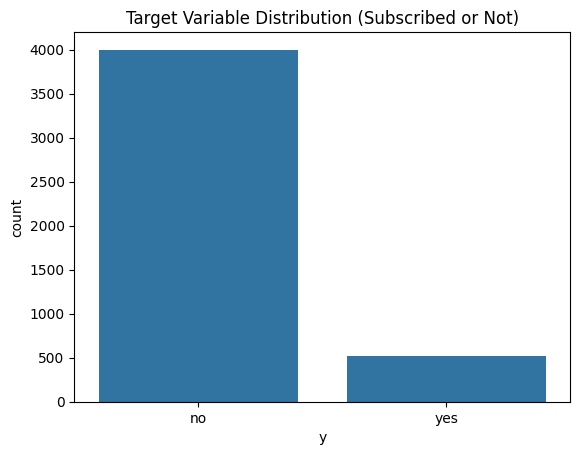

In [31]:
df.info()
print("Missing values:\n", df.isnull().sum())
sns.countplot(x="y", data=df)
plt.title("Target Variable Distribution (Subscribed or Not)")
plt.show()

In [32]:
cat_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:", cat_cols)

df_encoded = df.copy()
for col in cat_cols:
    if col != 'y': 
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])

df_encoded['y'] = df_encoded['y'].map({'yes': 1, 'no': 0})

df_encoded.head()

Categorical columns: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome', 'y'],
      dtype='object')


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,10,1,0,0,1787,0,0,0,19,10,79,1,-1,0,3,0
1,33,7,1,1,0,4789,1,1,0,11,8,220,1,339,4,0,0
2,35,4,2,2,0,1350,1,0,0,16,0,185,1,330,1,0,0
3,30,4,1,2,0,1476,1,1,2,3,6,199,4,-1,0,3,0
4,59,1,1,1,0,0,1,0,2,5,8,226,1,-1,0,3,0


In [33]:
X = df_encoded.drop("y", axis=1)
y = df_encoded["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (3164, 16)
Test set size: (1357, 16)


In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)

print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.94      1201
           1       0.47      0.18      0.26       156

    accuracy                           0.88      1357
   macro avg       0.68      0.58      0.60      1357
weighted avg       0.85      0.88      0.86      1357



In [35]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      1201
           1       0.64      0.26      0.37       156

    accuracy                           0.90      1357
   macro avg       0.78      0.62      0.66      1357
weighted avg       0.88      0.90      0.88      1357



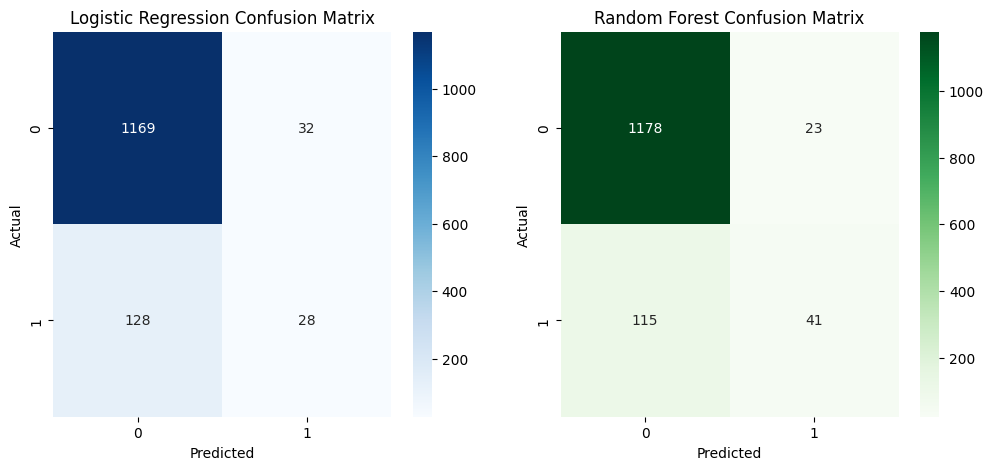

In [36]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Logistic Regression Confusion Matrix")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Greens", ax=ax[1])
ax[1].set_title("Random Forest Confusion Matrix")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.show()


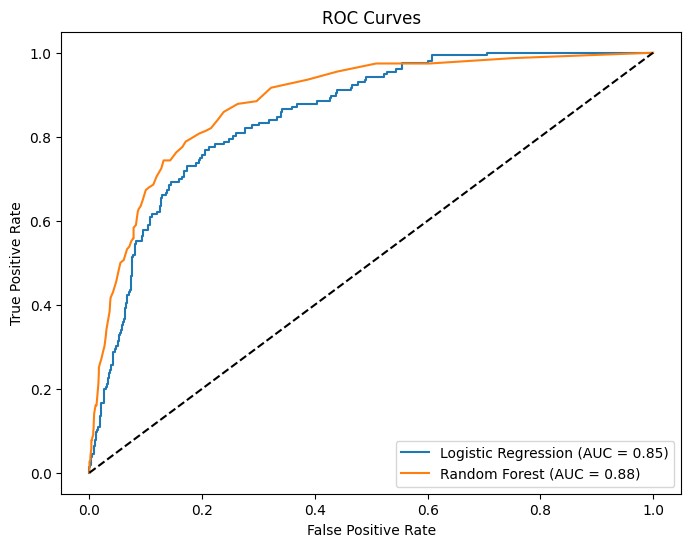

In [37]:
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

y_prob_rf = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

100%|===================| 2708/2714 [01:15<00:00]        

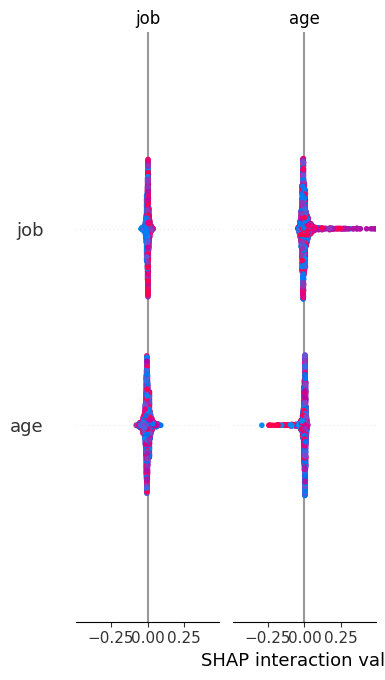


--- Prediction 1 ---


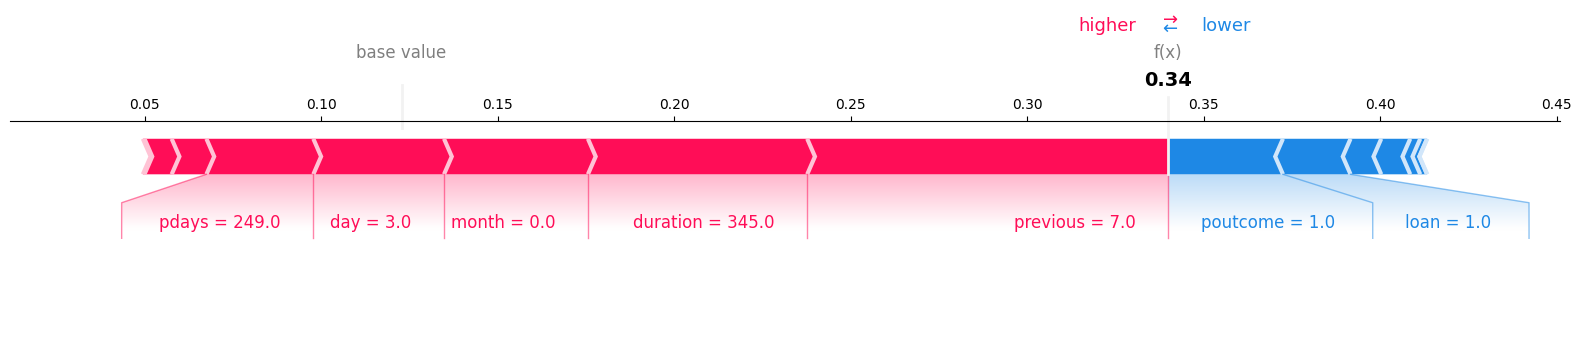


--- Prediction 2 ---


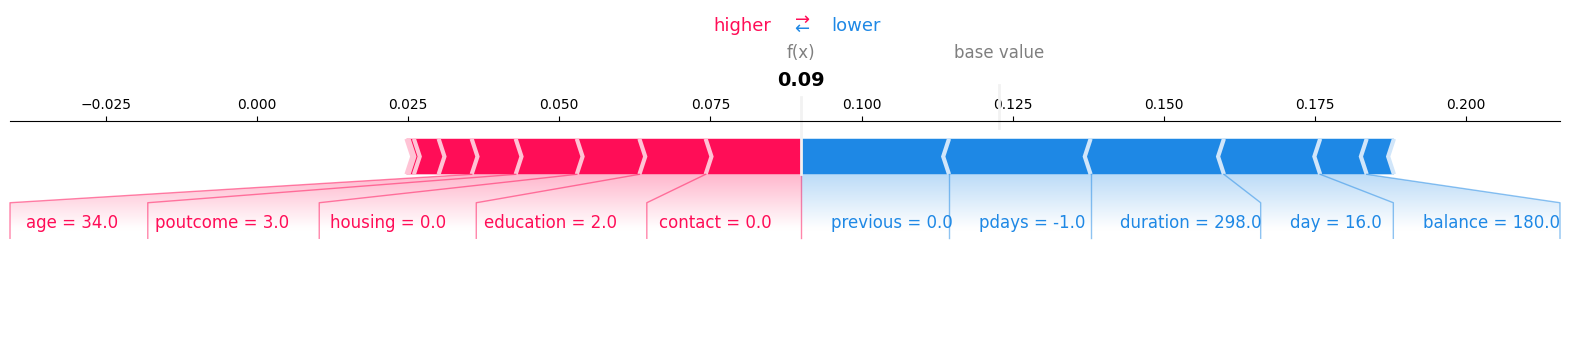


--- Prediction 3 ---


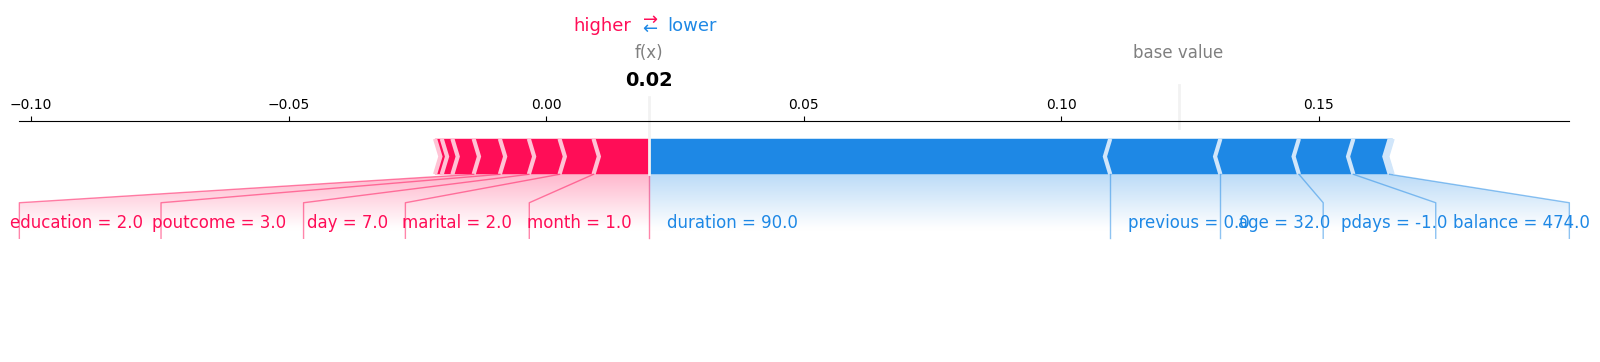


--- Prediction 4 ---


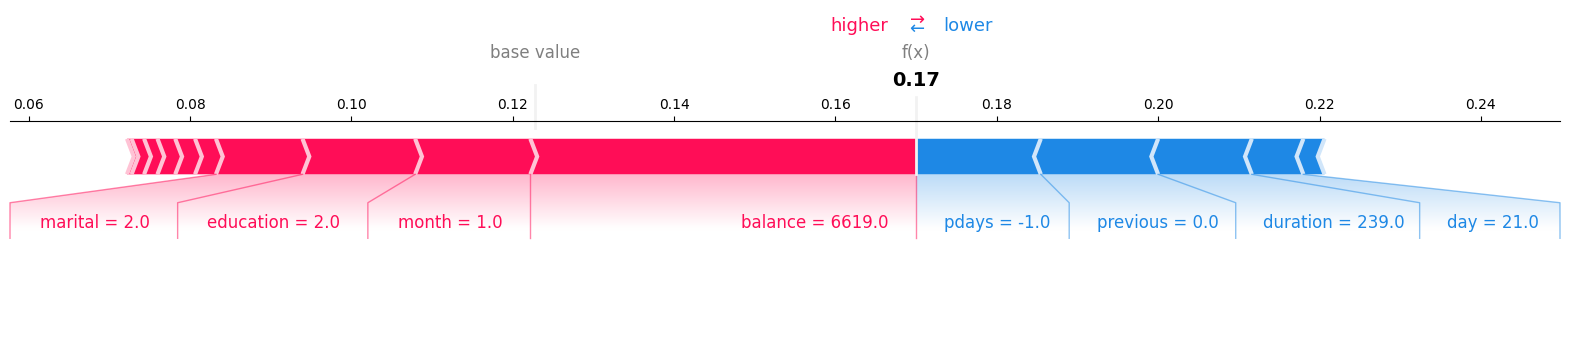


--- Prediction 5 ---


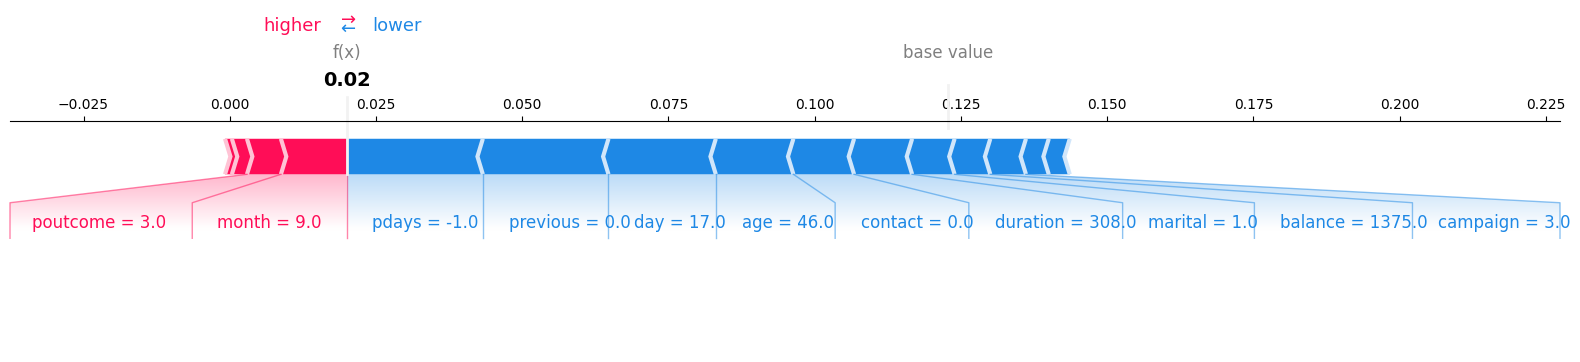

In [43]:
explainer = shap.Explainer(rf, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

for i in range(5):
    print(f"\n--- Prediction {i+1} ---")
    shap.plots.force(
        explainer.expected_value[1],   # pick the "yes" class
        shap_values[i].values[:,1],    # class 1 SHAP values
        X_test.iloc[i],
        matplotlib=True
    )